<a href="https://colab.research.google.com/github/sujiatong/30DayMap-Jiatong/blob/main/neural_network_regression_penn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building a Regression Model in PyTorch

In this tutorial, we are going to build our very own neural network for simple tasks. PyTorch library is for deep learning. Some applications of deep learning models are to solve regression or classification problems.
In this post, you will discover how to use PyTorch to develop and evaluate neural network models for regression problems.

After completing this post, you will know:

* How to load data from scikit-learn and adapt it for PyTorch models
* How to create a neural network for regerssion problem using PyTorch
* How to improve model performance with data preparation techniques

Ref: https://machinelearningmastery.com/building-a-regression-model-in-pytorch/

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as Data
from torch import optim
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from matplotlib import pyplot as plt

This is a dataset that describes the median house value for California districts. Each data sample is a census block group. The target variable is the median house value in USD 100,000 in 1990 and there are 8 input features, each describing something about the house. They are, namely,


* MedInc: median income in block group
* HouseAge: median house age in block group
* AveRooms: average number of rooms per household
* AveBedrms: average number of bedrooms per household
* Population: block group population
* AveOccup: average number of household members
* Latitude: block group centroid latitude
* Longitude: block group centroid longitude

We can easily download the data from `scikit`

In [ ]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()
print(data.feature_names)

X, y = data.data, data.target


['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [ ]:
import geopandas as gpd

#### Visualize the data

<Axes: >

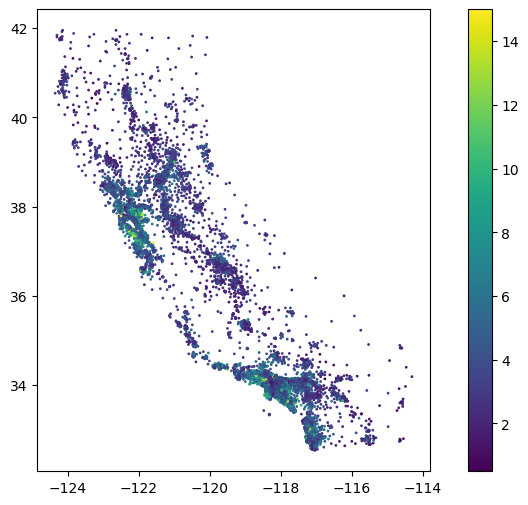

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Assuming X_train_raw contains latitude and longitude columns
# Replace 'latitude_column_index' and 'longitude_column_index' with the actual column indices
latitude_column_index = 6  # Replace with the index of your latitude column in X_train_raw
longitude_column_index = 7 # Replace with the index of your longitude column in X_train_raw

# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(X[:, longitude_column_index], X[:, latitude_column_index])]
gdf = gpd.GeoDataFrame(pd.DataFrame(X), geometry=geometry, crs="EPSG:4326")  # Assuming WGS 84 CRS

# Rename columns for easier access
gdf.columns = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'geometry']

# Plot the data
# Plot the data with color based on MedInc and small dot size
gdf.plot(column='MedInc',  # Color points based on the 'MedInc' column
         cmap='viridis',   # Use the 'viridis' colormap (you can change this)
         markersize=1,      # Set the marker size to 2 (adjust as needed)
         legend=True,       # Display a legend
         figsize=(10, 6))   # Adjust figure size if necessary


This is a regression problem. Unlike classification problems, the output variable is a continuous value. In case of neural networks, you usually use linear activation at the output layer (i.e., no activation) such that the output range theoretically can be anything from negative infinty to positive infinity.

Also for regression problems, you should never expect the model to predict the values perfectly. Therefore, you should care about how close the prediction is to the actual value. The loss metric that you can use for this is the mean square error (MSE) or mean absolute error (MAE). But you may also interested in the root mean squared error (RMSE) because that’s a metric in the same unit as your output variable.

Let’s try the traditional design of a neural network, namely, the pyramid structure. A pyramid structure is to have the number of neurons in each layer decreasing as the network progresses to the output. The number of input features is fixed, but you set a large number of neurons on the first hidden layer and gradually reduce the number in the subsequent layers. Because you have only one target in this dataset, the final layer should output only one value.

In [ ]:
import torch.nn as nn

# Define the model
model = nn.Sequential(
    nn.Linear(8, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

To train this network, you need to define a loss function. MSE is a reasonable choice. You also need an optimizer, such as Adam.

In [ ]:

import torch.nn as nn
import torch.optim as optim

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)


#### Split the dataset into trainning and testing
To train this model, you can use your usual training loop. In order to obtain an evaluation score so you are confident that the model works, you need to split the data into training and test sets. You may also want to avoid overfitting by keeping track on the test set MSE. The following is the training loop with the train-test split:

In [ ]:
import copy
import numpy as np
import torch
import tqdm
from sklearn.model_selection import train_test_split

# train-test split of the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# training parameters
n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

#### Prepare the GPU device on CoLab

In [ ]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: Tesla T4


In [ ]:
batch_start

tensor([    0,    10,    20,  ..., 14420, 14430, 14440])

#### Start training

In [ ]:
import copy
import torch
import tqdm


model.to(device)

# Move training and test data to the same device at the beginning
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")

        for start in bar:
            # Take a batch
            X_batch = X_train[start:start+batch_size].to(device)  # Move batch to device
            y_batch = y_train[start:start+batch_size].to(device)  # Move batch to device

            # Forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Print progress
            bar.set_postfix(mse=float(loss))

    # Evaluate accuracy at the end of each epoch
    model.eval()

    with torch.no_grad():  # No gradients needed during evaluation
        y_pred = model(X_test)  # X_test is already on the device
        mse = loss_fn(y_pred, y_test)  # y_test is already on the device
        mse = float(mse)

    history.append(mse)

    # Save best weights
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# Restore model and return best accuracy
model.load_state_dict(best_weights)

Epoch 75:   7%|▋         | 94/1445 [00:00<00:06, 197.08batch/s, mse=0.214]

In the training loop, tqdm is used to set up a progress bar and in each iteration step, MSE is calculated and reported. You can see how the MSE changed by setting the tqdm parameter disable above to False.

Note that in the training loop, each epoch is to run the forward and backward steps with the training set a few times to optimize the model weights, and at the end of the epoch, the model is evaluated using the test set. It is the MSE from the test set that is remembered in the list history. It is also the metric to evaluate a model, which the best one is stored in the variable best_weights.

After you run this, you will have the best model restored and the best MSE stored in the variable best_mse. Note that the mean square error is the average of the square of the difference between the predicted value and the actual value. The square root of it, RMSE, can be regarded as the average difference and it is numerically more useful.

In below, you can show the MSE and RMSE, and plot the history of MSE. It should be decreasing with the epochs.

MSE: 0.56
RMSE: 0.75


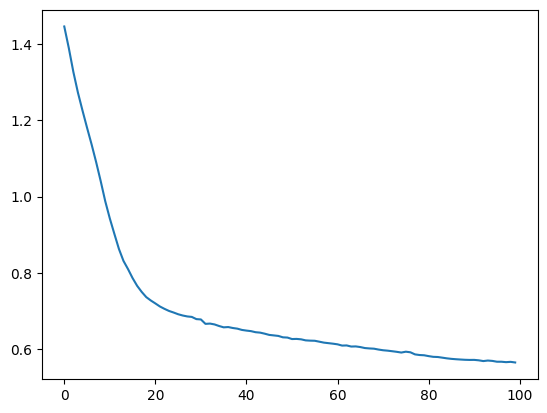

In [ ]:
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

Improving the Model with Preprocessing
In the above, you see the RMSE is 0.68. Indeed, it is easy to improve the RMSE by polishing the data before training. The problem of this dataset is the diversity of the features: Some are with a narrow range and some are wide. And some are small but positive while some are very negative. This indeed is not very nice to most of the machine learning model.

One way to improve this is to apply a standard scaler. It is to convert each feature into their standard score. In other words, for each feature
, you replace it with

 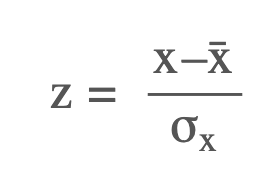

Where
 is the mean of
 and
 is the standard deviation. This way, every transformed feature is centered around 0 and in a narrow range that around 70% of the samples are between -1 to +1. This can help the machine learning model to converge.

You can apply the standard scaler from scikit-learn. The following is how you should modify the data preparation part of the above code:

In [ ]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

# Read data
data = fetch_california_housing()
X, y = data.data, data.target

# train-test split for model evaluation
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# Standardizing data
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [ ]:
import copy
import torch
import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

# Move training and test data to the same device at the beginning
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


n_epochs = 20

# Training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")

        for start in bar:
            # Take a batch
            X_batch = X_train[start:start+batch_size].to(device)  # Move batch to device
            y_batch = y_train[start:start+batch_size].to(device)  # Move batch to device

            # Forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Print progress
            bar.set_postfix(mse=float(loss))

    # Evaluate accuracy at the end of each epoch
    model.eval()

    with torch.no_grad():  # No gradients needed during evaluation
        y_pred = model(X_test)  # X_test is already on the device
        mse = loss_fn(y_pred, y_test)  # y_test is already on the device
        mse = float(mse)

    history.append(mse)

    # Save best weights
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# Restore model and return best accuracy
model.load_state_dict(best_weights)

Epoch 19: 100%|██████████| 1445/1445 [00:11<00:00, 122.80batch/s, mse=0.291]


<All keys matched successfully>

MSE: 0.42
RMSE: 0.65


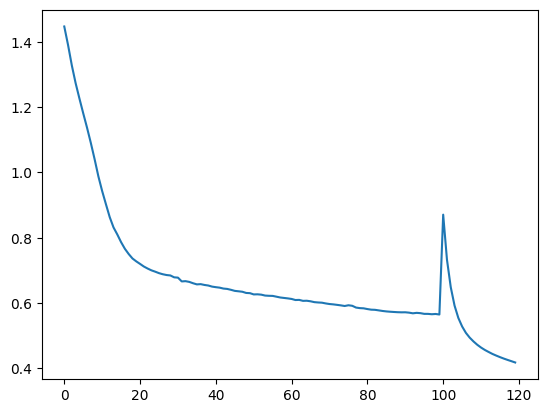

In [ ]:
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

However, you need to be careful at the end: When you use the trained model and apply to new data, you should apply the scaler to the input data before feed into the mode. That is, inference should be done as follows:


In [ ]:
model.eval()

with torch.no_grad():
    # Test out inference with 5 samples from the original test set
    for i in range(5):
        X_sample = X_test_raw[i: i+1]
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = model(X_sample.to(device))

        # Move tensors to CPU before converting to NumPy
        print(f"{X_test_raw[i]} -> {y_pred[0].cpu().numpy()} (expected {y_test[i].cpu().numpy()})")

[   2.2734       47.            6.00277778    1.22222222  966.
    2.68333333   38.09       -122.22      ] -> [1.2692525] (expected [0.887])
[   2.7273       44.            4.5625        1.02734375  509.
    1.98828125   32.73       -117.23      ] -> [2.0393507] (expected [2.697])
[ 3.5804e+00  4.5000e+01  4.9056e+00  1.0544e+00  1.2870e+03  2.0592e+00
  3.4140e+01 -1.1810e+02] -> [2.5008674] (expected [3.244])
[   6.7159       12.            7.28996283    1.04089219  985.
    3.66171004   37.3        -121.74      ] -> [2.820726] (expected [3.627])
[ 2.04320000e+00  1.80000000e+01  4.24350649e+00  1.01298701e+00
  1.18100000e+03  1.91720779e+00  3.85900000e+01 -1.21400000e+02] -> [1.0253723] (expected [1.568])


For the inference, you can choose not to use GPU

In [ ]:
import torch
from sklearn.preprocessing import StandardScaler

# ... (Your existing code for data loading, preprocessing, and model definition) ...

# Set device to CPU
device = torch.device("cpu")
model.to(device)  # Move the model to the CPU

model.eval()

with torch.no_grad():
    # Test out inference with 5 samples from the original test set
    for i in range(5):
        X_sample = X_test_raw[i: i+1]
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = model(X_sample)  # No need to move X_sample to device, as it's already on CPU

        # Move tensors to CPU before converting to NumPy (This should still be used as a good practice in case device is accidentally set to GPU elsewhere in your code.)
        print(f"{X_test_raw[i]} -> {y_pred[0].cpu().numpy()} (expected {y_test[i].cpu().numpy()})")

[   2.2734       47.            6.00277778    1.22222222  966.
    2.68333333   38.09       -122.22      ] -> [1.2692528] (expected [0.887])
[   2.7273       44.            4.5625        1.02734375  509.
    1.98828125   32.73       -117.23      ] -> [2.0393505] (expected [2.697])
[ 3.5804e+00  4.5000e+01  4.9056e+00  1.0544e+00  1.2870e+03  2.0592e+00
  3.4140e+01 -1.1810e+02] -> [2.5008674] (expected [3.244])
[   6.7159       12.            7.28996283    1.04089219  985.
    3.66171004   37.3        -121.74      ] -> [2.820726] (expected [3.627])
[ 2.04320000e+00  1.80000000e+01  4.24350649e+00  1.01298701e+00
  1.18100000e+03  1.91720779e+00  3.85900000e+01 -1.21400000e+02] -> [1.0253723] (expected [1.568])


In [ ]:
X.astype(np.float32)

array([[   8.3252   ,   41.       ,    6.984127 , ...,    2.5555556,
          37.88     , -122.23     ],
       [   8.3014   ,   21.       ,    6.2381372, ...,    2.1098418,
          37.86     , -122.22     ],
       [   7.2574   ,   52.       ,    8.288136 , ...,    2.80226  ,
          37.85     , -122.24     ],
       ...,
       [   1.7      ,   17.       ,    5.2055426, ...,    2.3256352,
          39.43     , -121.22     ],
       [   1.8672   ,   18.       ,    5.329513 , ...,    2.1232092,
          39.43     , -121.32     ],
       [   2.3886   ,   16.       ,    5.254717 , ...,    2.616981 ,
          39.37     , -121.24     ]], dtype=float32)

In [ ]:
class DataMaker(Data.Dataset):
    def __init__(self, X, y):
        # scaler = MinMaxScaler()
        scaler = StandardScaler()
        self.targets = scaler.fit_transform(X.astype(np.float32))
        # self.targets = scaler.fit_transform(X.cpu().numpy().astype(np.float32))
        self.labels = y.astype(np.float32)
        self.X = X # Store X for indexing

    # def __getitem__(self, i):
    #     return self.targets[i, :], self.labels[i]

    def __getitem__(self, i):
      return self.targets[i, :], self.labels[i]  # Use i instead of index

    def __len__(self):
        return len(self.targets)


In [ ]:
class Model(nn.Module):
    def __init__(self, n_features, hiddenA, hiddenB):
        super(Model, self).__init__()
        self.linearA = nn.Linear(n_features, hiddenA)
        self.linearB = nn.Linear(hiddenA, hiddenB)
        self.linearC = nn.Linear(hiddenB, 1)

    def forward(self, x):
        yA = F.relu(self.linearA(x))
        yB = F.relu(self.linearB(yA))
        return self.linearC(yB)


In [ ]:
torch.manual_seed(1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

train_set = DataMaker(X_train, y_train)
test_set = DataMaker(X_test, y_test)


In [ ]:
bs = 25 #batch size
train_loader = Data.DataLoader(train_set, batch_size=bs, shuffle=True)
test_loader = Data.DataLoader(test_set, batch_size=bs, shuffle=True)


In [ ]:
n_features = 8
net = Model(n_features, 100, 50)


In [ ]:
criterion = nn.MSELoss(size_average=False)
optimizer = optim.Adam(net.parameters(), lr=0.01)


/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


#### Start training

In [ ]:
from tqdm import tqdm # Change the import statement

n_epochs = 200
all_losses = []
for epoch in range(n_epochs):
    progress_bar = tqdm(train_loader, leave=False)
    losses = []
    total = 0
    for inputs, target in progress_bar:
        optimizer.zero_grad()
        y_pred = net(inputs)
        loss = criterion(y_pred, torch.unsqueeze(target,dim=1))

        loss.backward()

        optimizer.step()

        progress_bar.set_description(f'Loss: {loss.item():.3f}')

        losses.append(loss.item())
        total += 1

    epoch_loss = sum(losses) / total
    all_losses.append(epoch_loss)

    mess = f"Epoch #{epoch+1}\tLoss: {all_losses[-1]:.3f}"
    # tqdm.tqdm.write(mess)

# References
- Helber, P., Bischke, B., Dengel, A., & Borth, D. (2019). Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 12(7), 2217-2226.
- Wang, Y., Braham, N. A. A., Xiong, Z., Liu, C., Albrecht, C. M., & Zhu, X. X. (2023). SSL4EO-S12: A large-scale multimodal, multitemporal dataset for self-supervised learning in Earth observation [Software and Data Sets]. IEEE Geoscience and Remote Sensing Magazine, 11(3), 98-106.